# Marvel Clusters

# Imports

In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn.cluster as cluster
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture as GMM
from sklearn.cluster import AgglomerativeClustering

from scipy.cluster.hierarchy import dendrogram

# Extraction

In [2]:
df = pd.read_csv('../../datasets/marvel-powers.csv')
df.head()

,Name,Alignment,Intelligence,Strength,Speed,Durability,Power,Combat,Total
0,3-D Man,good,50,31,43,32,25,52,233
1,A-Bomb,good,38,100,17,80,17,64,316
2,Abe Sapien,good,88,14,35,42,35,85,299
3,Abin Sur,good,50,90,53,64,84,65,406
4,Abomination,bad,63,80,53,90,55,95,436


# Analysis and Transformation

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 611 entries, 0 to 610
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Name          611 non-null    object
 1   Alignment     608 non-null    object
 2   Intelligence  611 non-null    int64 
 3   Strength      611 non-null    int64 
 4   Speed         611 non-null    int64 
 5   Durability    611 non-null    int64 
 6   Power         611 non-null    int64 
 7   Combat        611 non-null    int64 
 8   Total         611 non-null    int64 
dtypes: int64(7), object(2)
memory usage: 43.1+ KB


In [4]:
# verificar si hacen falta datos
df.isna().sum()

Name            0
Alignment       3
Intelligence    0
Strength        0
Speed           0
Durability      0
Power           0
Combat          0
Total           0
dtype: int64

In [5]:
# solo hay un dato faltante en 3 columnas por lo qe podemos eliminarlos sin comprometer la data
df = df.dropna()

In [6]:
df.isna().sum()

Name            0
Alignment       0
Intelligence    0
Strength        0
Speed           0
Durability      0
Power           0
Combat          0
Total           0
dtype: int64

In [7]:
# selccionamos variables numericas para entrenar el modelo
n_cols = [col for col in df.columns.values if col not in ['Name', 'Alignment']]
n_cols

['Intelligence', 'Strength', 'Speed', 'Durability', 'Power', 'Combat', 'Total']

# Clustering

## Identifing number of clusters

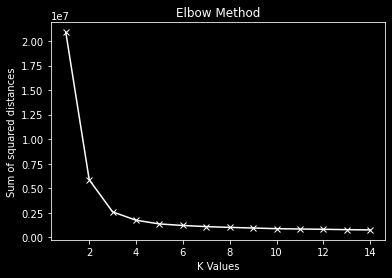

In [8]:
#Elbow Method/ Método de codo nos funciona apra identificar número adecuado de posibles clúster
K = range(1,15)
sum_of_squared_distances = []
for k in K:
  model = KMeans(n_clusters=k).fit(df[n_cols])
  sum_of_squared_distances.append(model.inertia_)
plt.plot(K, sum_of_squared_distances,'wx-')
plt.xlabel('K Values')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method')
plt.show();

## KMean Clusterization

In [9]:
# la gráfica sugiere que 3 clusters es adecuado para el set de datos
kmeans = KMeans(n_clusters=3, random_state=111)

In [10]:
# entrenamos el modelo
df_clusters = kmeans.fit(df[n_cols])
df_clusters

KMeans(n_clusters=3, random_state=111)

In [11]:
# asignamos un grupo a cada observación y luego agregamos este dato al dataset
df['cluster'] = df_clusters.fit_predict(df[n_cols])
df.cluster.value_counts()

2    251
0    184
1    173
Name: cluster, dtype: int64

In [12]:
# observaciones cluster 0
df[df.cluster == 0]

,Name,Alignment,Intelligence,Strength,Speed,Durability,Power,Combat,Total,cluster
7,Adam Strange,good,1,1,1,1,0,1,5,0
8,Agent 13,good,1,1,1,1,0,1,5,0
9,Agent Bob,good,10,8,13,5,5,20,61,0
13,Alex Woolsly,good,1,1,1,1,0,1,5,0
15,Allan Quatermain,good,1,1,1,1,0,1,5,0
...,...,...,...,...,...,...,...,...,...,...
591,White Queen,good,1,1,1,1,0,1,5,0
595,Wiz Kid,good,1,1,1,1,0,1,5,0
601,Wondra,good,1,1,1,1,0,1,5,0
602,Wyatt Wingfoot,good,10,10,12,1,1,56,90,0


In [13]:
# poder medio en cada 1 de los 3 clusters
df.groupby(['cluster'])['Total'].mean()

cluster
0      8.429348
1    421.849711
2    251.171315
Name: Total, dtype: float64

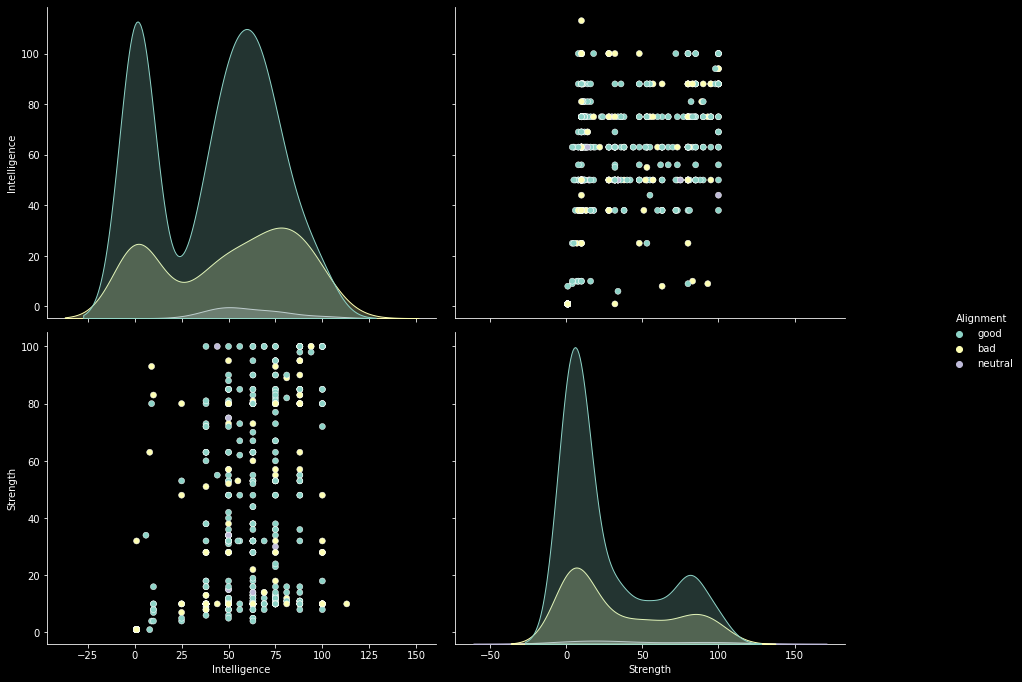

In [14]:
g=sns.pairplot(data=df, vars=['Intelligence','Strength'], hue='Alignment', height=3, kind= 'scatter')
g.fig.set_size_inches(15,10);

## Hierarchical Clustering

In [15]:
# tomamos una muestra del dataset para generar un dendrograma claro y ordenado
df_sample = df[n_cols].sample(n=100)
hier_clust = AgglomerativeClustering(linkage='ward')
df_hier = hier_clust.fit(df_sample)

In [16]:
# función para plotter un dendrogram
def plot_dendrogram(model, **kwargs):
    children = model.children_
    distance = np.arange(children.shape[0])
    no_of_observations = np.arange(2, children.shape[0]+2)
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)
    dendrogram(linkage_matrix, **kwargs)

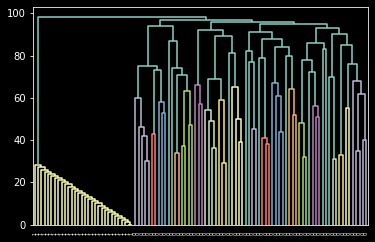

In [17]:
# generamos el dendogram del modelo
plot_dendrogram(df_hier, labels=df_hier.labels_);

In [18]:
df[n_cols].head()

,Intelligence,Strength,Speed,Durability,Power,Combat,Total
0,50,31,43,32,25,52,233
1,38,100,17,80,17,64,316
2,88,14,35,42,35,85,299
3,50,90,53,64,84,65,406
4,63,80,53,90,55,95,436


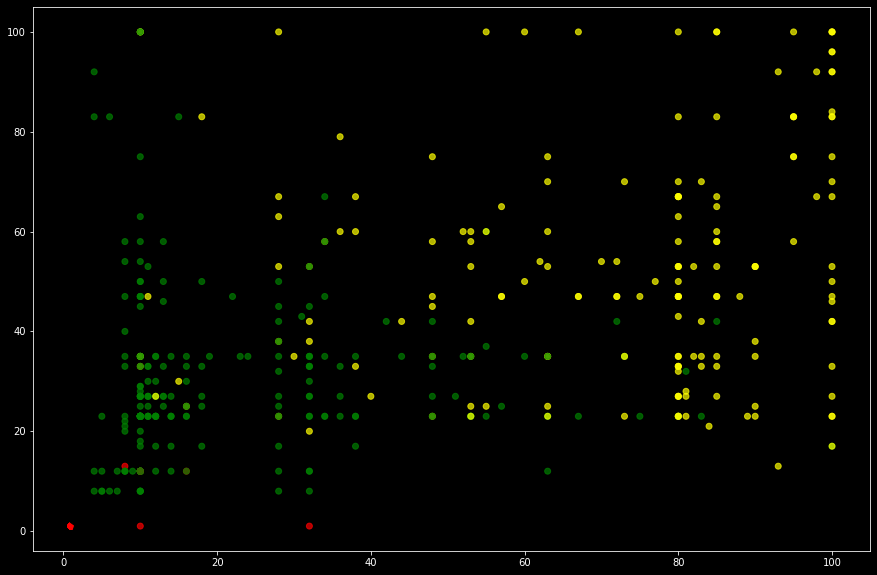

In [19]:
X = df[n_cols].to_numpy()
labels = kmeans.predict(X)
center = kmeans.cluster_centers_
colors = ["red","yellow","green","blue"]

asignar=[]
for row in labels:
  asignar.append(colors[row])

plt.figure(figsize=(15,10))
feature_1 = X[:,1]
feature_2 = X[:,2]
plt.scatter(feature_1, feature_2, c=asignar, alpha=.7)
plt.scatter(center[:,0], center[:,1], marker = "*", c='black', s=240)
plt.show;

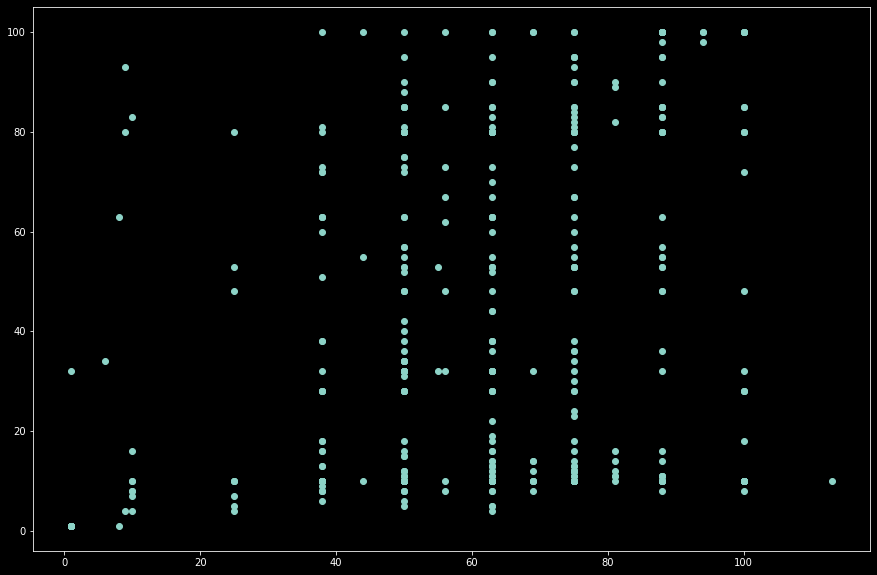

In [20]:
plt.figure(figsize=(15,10))
plt.scatter(X[:,0],X[:,1]);

## Nearest Neighbor Clustering

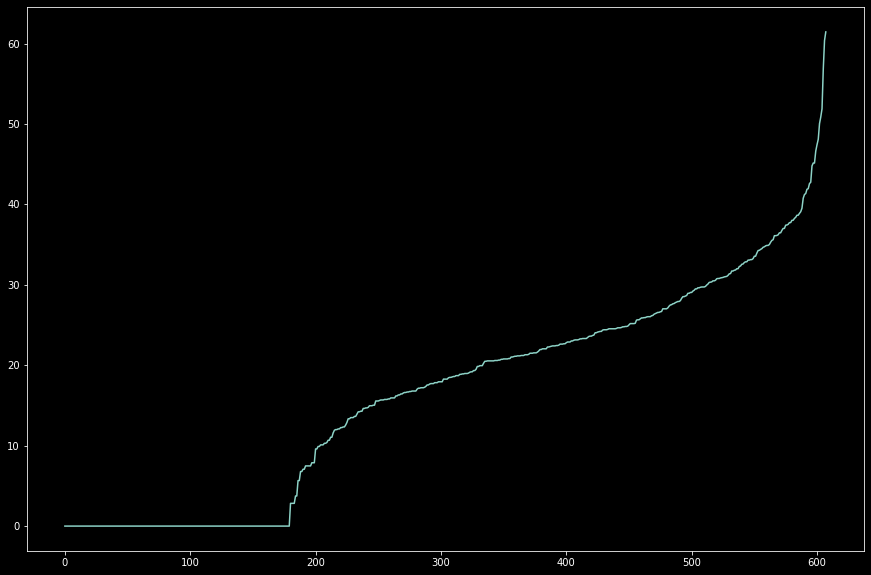

In [34]:
# Clusterización con Vecinos Cercanos
nearest_neighbors = NearestNeighbors(n_neighbors = 5)
nearest_neighbors.fit(X)
distances, indices = nearest_neighbors.kneighbors(X)
distances= np.sort(distances, axis=0)[:,1]
plt.figure(figsize=(15,10))
plt.plot(distances)
plt.show()

In [35]:
# Min_samples = si tenemos más de 2 minesiones, min samples = 2*dim , en este caso sería de 4
dbscan_1 = DBSCAN(eps=.20, min_samples = 4)
dbscan_1.fit(X)
labels= dbscan_1.labels_
df['cluster_hdbscan'] = labels
df.cluster_hdbscan.value_counts()

-1    432
 0    176
Name: cluster_hdbscan, dtype: int64

In [23]:
labels_mask_general = np.zeros_like(labels,dtype=bool)
n_noise_ = list(labels).count(-1)
unique_labels = set(labels)
n_clusters_ = len (set(labels))- (1 if -1 in labels else 0 )

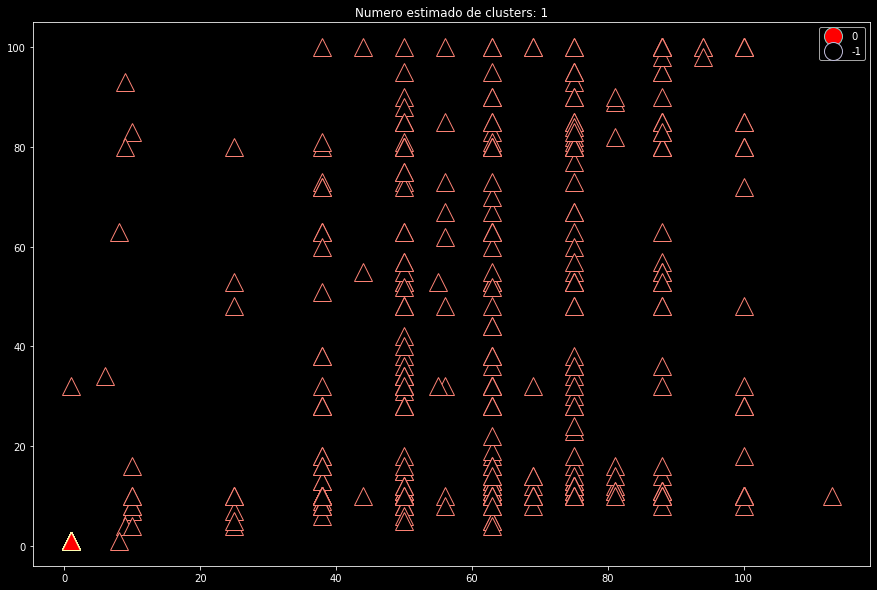

In [24]:
# Visualizacion distancia .15
plt.figure(figsize=(15,10))
for k, col in zip(unique_labels, colors):
  if k==-1:
    col = "k"

  clase = (labels ==k)  
  # Es para lo que NO es ruido
  xy = X[clase & labels_mask_general]
  plt.plot(xy[:,0],xy[:,1],"o", markerfacecolor=col, markersize = 18, label=k, alpha =1)
    # Es para lo que SI es ruido
  xy = X[clase & ~labels_mask_general]
  plt.plot(xy[:,0],xy[:,1],"^", markerfacecolor=col, markersize = 18, alpha =1)

plt.title("Numero estimado de clusters: %d" %n_clusters_)
plt.legend()
plt.show()

## Gaussian Misture

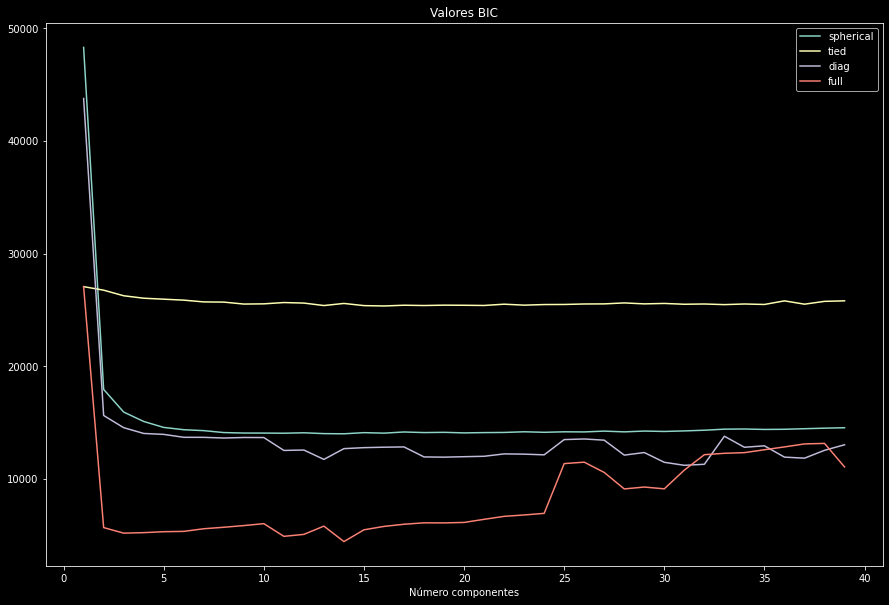

In [25]:
fig, ax = plt.subplots(figsize=(15, 10))

n_components = range(1, 40)
covariance_types = ['spherical', 'tied', 'diag', 'full']

for covariance_type in covariance_types:
    valores_bic = []
    
    for i in n_components:
        modelo = GMM(n_components=i, covariance_type=covariance_type, random_state=123)
        modelo = modelo.fit(X)
        valores_bic.append(modelo.bic(X))
        
    ax.plot(n_components, valores_bic, label=covariance_type)
ax.set_title("Valores BIC")
ax.set_xlabel("Número componentes")
ax.legend();

## GMM

<Figure size 2160x720 with 0 Axes>

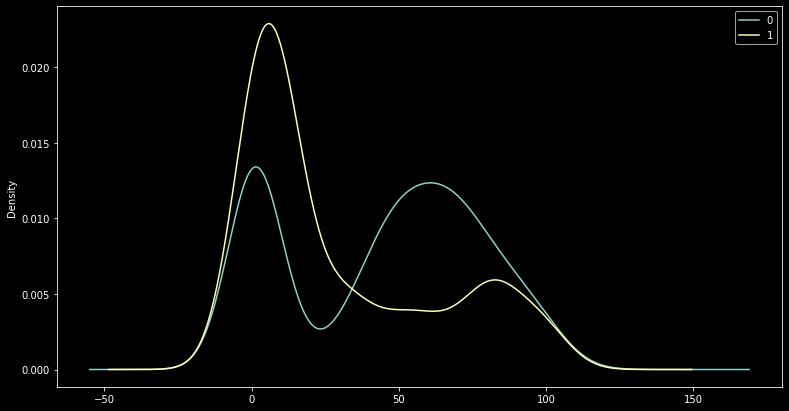

In [26]:
x_frame = pd.DataFrame(X)
x_frame = x_frame[[0,1]]
plt.figure(figsize=(30,10))
x_frame.plot(kind='kde', figsize=(13,7))
plt.show()

In [27]:
gm =GMM( n_components = 5, covariance_type = 'full', random_state=123)
gm.fit(X)
labels= gm.predict(X)
frame = pd.DataFrame(X)
frame['cluster']=labels
frame.head()

,0,1,2,3,4,5,6,cluster
0,50,31,43,32,25,52,233,2
1,38,100,17,80,17,64,316,2
2,88,14,35,42,35,85,299,4
3,50,90,53,64,84,65,406,2
4,63,80,53,90,55,95,436,3


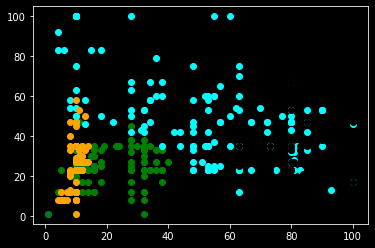

In [28]:
color = ['blue','green','cyan','black','orange']
for k in range(0,5):
  data = frame[frame["cluster"]==k]
  plt.scatter(data[1], data[2],c=color[k])
plt.show()  

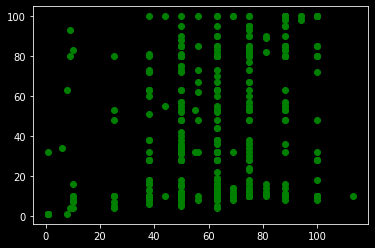

In [29]:
plt.scatter(X.T[0], X.T[1], color='g');

# General functión to plot clustering

In [30]:
def plot_clusters(data, algorithm, args, kwds):
  start_time= time.time()
  labels = algorithm(*args, **kwds).fit_predict(data)
  end_time= time.time()
  palette = sns.color_palette('deep',np.unique(labels).max()+1)
  colors = [palette[x] if x>=0 else (0.0,0.0,0.0) for x in labels]
  plt.scatter(data.T[0],data.T[1], c= colors)
  plt.title('Cluster encontrados por {}'.format(str(algorithm.__name__)),fontsize=24)
  plt.text(-.6,-25,'Clusterizacion en {:.2f} segs'.format(end_time - start_time), fontsize =14)

## Kmean Cluster

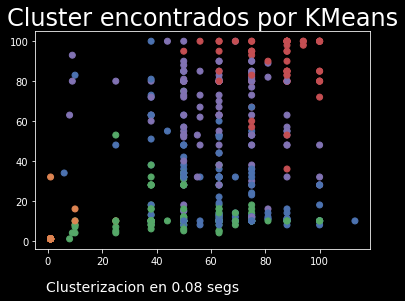

In [31]:
plot_clusters(X, cluster.KMeans, (), {'n_clusters':5,'random_state':123})

## DBScan Cluster

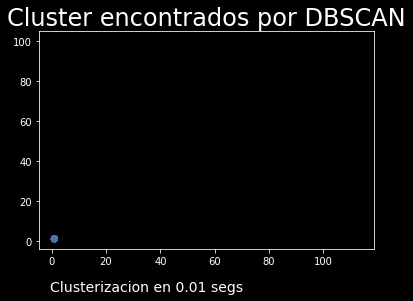

In [32]:
plot_clusters(X, cluster.DBSCAN, (), {'eps':7.2})

## GMM

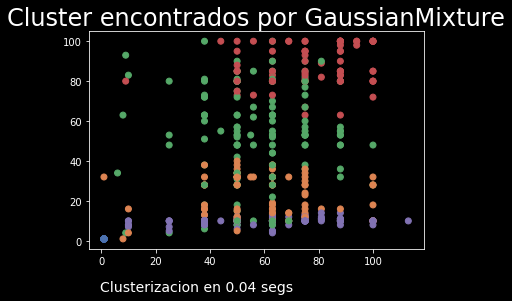

In [33]:
plot_clusters(X, GMM, (), {'n_components':5,'covariance_type':'full','random_state':123})